# Data in Python

by **Professor Throckmorton**  
for *Time Series Econometrics*  
W&amp;M ECON 408/PUBP 616  
<a href="data-in-python.slides.html">Slides</a>

## Summary

This Jupyter Notebook contains cells with examples of getting, plotting, and transforming time-series data.

## Import Libraries

- We will use the ``matplotlib`` and ``numpy`` libraries again (see [Jupyter Notebook](jupyter-notebook.ipynb)). 
- Additionally, we'll use the `pandas` library to read data from a file.
    - `pandas` provides "high-performance, easy-to-use data structures and data analysis tools for the Python programming language."
    - Please see the [pandas user guide](https://pandas.pydata.org/docs/user_guide/index.html) for more information.

## Reading data

- There are a lot of different sources for economic time-series data, and [FRED](https://fred.stlouisfed.org/) is an easy place to start.
- You will need to create an account on FRED, request an API Key, and store the key in a file, e.g., `fred_api_key.txt`, in the same folder as this Notebook. It's good practice to keep your API Key secret.
- First, let's get and plot data on U.S. real GDP.
- The `fredapi` library contains the method `Fred` to get the data from the server.
- We then convert the series to a `pandas` DataFrame so it is easy to transform and plot.

In [1]:
# Libraries
from fredapi import Fred
import pandas as pd
# Read data
fred_api_key = pd.read_csv('fred_api_key.txt', header=None)
fred = Fred(api_key=fred_api_key.iloc[0,0])
data = fred.get_series('GDPC1').to_frame(name='RGDP')
# Print data
print(f'number of rows/quarters = {len(data)}')
print(data.head(2))
print(data.tail(2))

number of rows/quarters = 314
                RGDP
1947-01-01  2182.681
1947-04-01  2176.892
                 RGDP
2025-01-01  23512.717
2025-04-01  23685.287


- Jan 1 corresponds to the first quarter (Q1) of the year, and Apr 1 is Q2, July 1 is Q3, and Oct 1 is Q4.
- Units are billions of chained 2017 dollars (see [Real Gross Domestic Product notes](https://fred.stlouisfed.org/series/GDPC1)).
- `print(f'...')` formats a string to display (see [f-strings](https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/)).
- `print(rgdp.head(2))` shows the first two rows of `rgdp`, and `print(rgdp.tail(2))` shows the last two rows, which helps us see if we read the right data.

### Datetime
- We can reference values with a datetime, e.g., `data.RGDP['2025-01-01']`.

In [2]:
# Latest Real GDP value (with formatting)
print(f'Latest Real GDP value (2025Q1) = \
${data.RGDP['2025-01-01']:,.0f}B')

Latest Real GDP value (2025Q1) = $23,513B


- In the `print` statement, `:,.0f` adds a comma delimiter and removes the decimal places.

## Plotting data

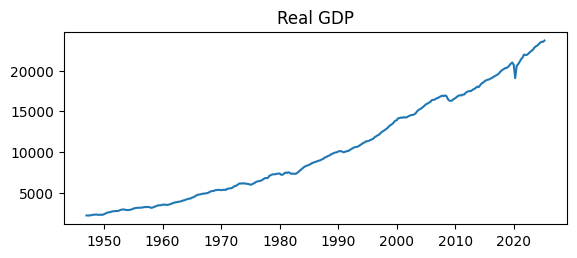

In [3]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(6.5,2.5))
ax.plot(data);
ax.set_title('Real GDP');

`ax.plot` automatically puts the datetimes on the horizontal axis.

**What's wrong with that plot?**
1) The values on the vertical axis have no units.
2) An absence of grid lines makes it difficult to read values from the series.

Let's fix those issues with `ax.yaxis.set_major_formatter` and `ax.grid`.

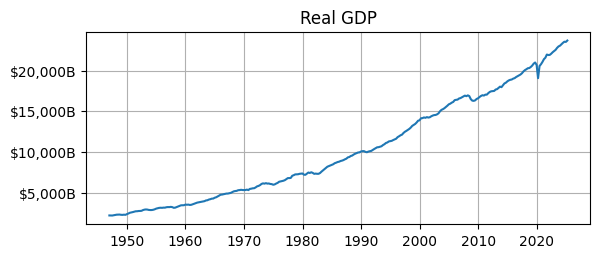

In [4]:
fig, ax = plt.subplots(figsize=(6.5,2.5))
ax.plot(data)
ax.set_title('Real GDP')
ax.yaxis.set_major_formatter('${x:,.0f}B')
ax.grid()

## Transforming data

**We don't usually look at the time series of real GDP in levels like that. Why?**
1) It has a clear exponential trend, which we can easily remove with the natural log, available in the `numpy` library as `np.log`.
2) We usually care about the business cycle. Is real GDP growing (in an expansion) or shrinking (in a recession). We can see the little wiggles in the level above, but there are better ways to visualize those ups and downs.

When real GDP is reported, we might read the latest value, or we would look at recent growth rates. Growth rates will highlight the expansions and recessions clearly. 

### Natural Log

First, let's remove the exponential trend by transforming the data with `np.log`.

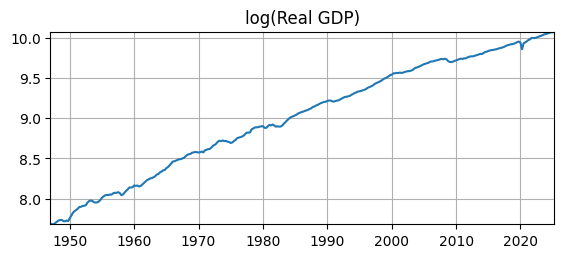

In [5]:
#   Scientific computing
import numpy as np
# Natural log of Real GDP
logdata = np.log(data)
fig, ax = plt.subplots(figsize=(6.5,2.5))
ax.plot(logdata)
ax.set_title('log(Real GDP)')
ax.grid()
ax.autoscale(tight=True)

### Diff Operator

Next, let's calculate the percent change from the same quarter one year ago.
- We can use the `diff` method (an implementation of the [difference operator](https://en.wikipedia.org/wiki/Lag_operator#Difference_operator)).
- Since the data has a quarterly frequency, we want to difference the data from $4$ quarters in the past, e.g., `logdata.diff(4)`.
- We can approximate the percent change with the difference between the logged values over time, i.e., $y_t/y_{t-4} - 1 \approx \log(y_t) - \log(y_{t-4})$.
- See this [stack exchange question and top answer](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th) for more on that.

In [6]:
# Real GDP Growth Rate (percent change from 4 quarters ago)
logdata_growth = 100*logdata.diff(4)

# Latest Real GDP value
print(f'2024Q3 real GDP Year over Year Growth Rate = \
{logdata_growth.RGDP['2025-01-01']:.2f}%')

2024Q3 real GDP Year over Year Growth Rate = 1.97%


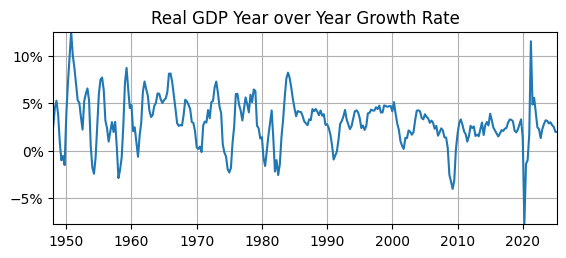

In [7]:
# Plot Real GDP growth rate
fig, ax = plt.subplots(figsize=(6.5,2.5))
ax.plot(logdata_growth)
ax.set_title('Real GDP Year over Year Growth Rate')
ax.yaxis.set_major_formatter('{x:.0f}%')
ax.grid()
ax.autoscale(tight=True)

**Now that we have transformed real GDP into something we can interpret, what do we see?** (i.e., "eyeball" econometrics)
1) Real GDP growth rates usually vary between $-2\%$ and $8\%$.
2) They are more often positive than negative.
3) After 1985, the local maximums are around $5\%$, down from around $8\%$ before 1985.
4) The last two declines (in 2008 and 2020) in real GDP were the biggest since the beginning of the sample (1947).

### Average

Let's compare the average real GDP growth rate before and after 1985 using `np.mean` and referencing a range of values between two datetimes, e.g., ``rgdp_growth['VALUE']['1947-01-01':'1984-10-01']``.

In [8]:
# Subsamples
mean_pre85 = logdata_growth.RGDP['1947-01-01':'1984-10-01'].mean()
mean_post85 = logdata_growth.RGDP['1985-01-01':'2024-01-01'].mean()

# Display means
print('Avg. Real GDP Growth')
print(f'  before 1985 = {mean_pre85:.1f}%')
print(f'  after 1985 = {mean_post85:.1f}%')

Avg. Real GDP Growth
  before 1985 = 3.6%
  after 1985 = 2.6%


Real GDP growth has declined on average by $1$ percentage point after 1985, which is significant when compounding that growth rate over $40$ years.

## Conclusion

We used `fredapi` and `pandas` to get data and put it in a DataFrame. That allowed us to plot and transform the data to a point where we could summarize and interpret it.